# CROP YIELD ESTIMATE CHALLENGE

The data was collected through a survey conducted across multiple districts in India. It consists of a variety of factors that could potentially impact the yield of rice crops. These factors include things like the type and amount of fertilizers used, the quantity of seedlings planted, methods of preparing the land, different irrigation techniques employed, among other features. The dataset comprises more than 5000 data points, each having more than 40 features.

In [ ]:
pip install lazypredict

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.linear_model import ElasticNet, Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.decomposition import PCA

import lazypredict


%matplotlib inline

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load files
data_path = '/content/drive/MyDrive/digital-green-crop-yield-estimate-challenge/'
train_df = pd.read_csv(data_path + 'Train.csv')
test = pd.read_csv(data_path + 'Test.csv')
sample_submission = pd.read_csv(data_path + 'SampleSubmission.csv')
var_desc = pd.read_csv(data_path + 'VariableDescription.csv')

In [ ]:
# Preview files
train_df.head(3)

,ID,District,Block,CultLand,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,RcNursEstDate,...,Harv_method,Harv_date,Harv_hand_rent,Threshing_date,Threshing_method,Residue_length,Residue_perc,Stubble_use,Acre,Yield
0,ID_GTFAC7PEVWQ9,Nalanda,Noorsarai,45,40,TractorPlough FourWheelTracRotavator,2022-07-20,5,Manual_PuddledRandom,2022-06-27,...,machine,2022-11-16,NaN,2022-11-16,machine,30,40,plowed_in_soil,0.312500,600
1,ID_TK40ARLSPOKS,Nalanda,Rajgir,26,26,WetTillagePuddling TractorPlough FourWheelTrac...,2022-07-18,5,Manual_PuddledRandom,2022-06-20,...,hand,2022-11-25,3.0,2022-12-24,machine,24,10,plowed_in_soil,0.312500,600
2,ID_1FJY2CRIMLZZ,Gaya,Gurua,10,10,TractorPlough FourWheelTracRotavator,2022-06-30,6,Manual_PuddledRandom,2022-06-20,...,hand,2022-12-12,480.0,2023-01-11,machine,30,10,plowed_in_soil,0.148148,225


In [ ]:
test.head(3)

,ID,District,Block,CultLand,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,RcNursEstDate,...,MineralFertAppMethod.1,Harv_method,Harv_date,Harv_hand_rent,Threshing_date,Threshing_method,Residue_length,Residue_perc,Stubble_use,Acre
0,ID_F9XXEXN2ADR2,Jamui,Khaira,20,13,TractorPlough,2022-07-24,4,Manual_PuddledLine,2022-07-03,...,Broadcasting,hand,2022-12-02,500.0,2022-12-28,hand,22,10,plowed_in_soil,0.272727
1,ID_SO3VW2X4QO93,Jamui,Khaira,25,25,TractorPlough,2022-07-24,5,Manual_PuddledRandom,2022-07-08,...,Broadcasting,hand,2022-11-12,150.0,2022-12-20,machine,28,10,plowed_in_soil,0.227273
2,ID_UKUQ7JM8E894,Nalanda,Rajgir,30,30,WetTillagePuddling TractorPlough FourWheelTrac...,2022-07-07,5,Manual_PuddledRandom,2022-06-24,...,Broadcasting,hand,2022-11-24,1200.0,2022-12-05,machine,28,10,plowed_in_soil,0.281250


## Data Understanding

In [ ]:
# number of rows and columns
print(f'Shape of train data: {train_df.shape}')
print(f'Shape of test data: {test.shape}')

Shape of train data: (3870, 44)
Shape of test data: (1290, 43)


In [ ]:
# summary of the dataframe
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3870 entries, 0 to 3869
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  3870 non-null   object 
 1   District                            3870 non-null   object 
 2   Block                               3870 non-null   object 
 3   CultLand                            3870 non-null   int64  
 4   CropCultLand                        3870 non-null   int64  
 5   LandPreparationMethod               3870 non-null   object 
 6   CropTillageDate                     3870 non-null   object 
 7   CropTillageDepth                    3870 non-null   int64  
 8   CropEstMethod                       3870 non-null   object 
 9   RcNursEstDate                       3787 non-null   object 
 10  SeedingSowingTransplanting          3870 non-null   object 
 11  SeedlingsPerPit                     3581 no

In [ ]:
# summary statistics
train_df.describe()

,CultLand,CropCultLand,CropTillageDepth,SeedlingsPerPit,TransplantingIrrigationHours,TransIrriCost,StandingWater,Ganaura,CropOrgFYM,NoFertilizerAppln,...,BasalUrea,1tdUrea,1appDaysUrea,2tdUrea,2appDaysUrea,Harv_hand_rent,Residue_length,Residue_perc,Acre,Yield
count,3870.000000,3870.000000,3870.000000,3581.000000,3677.000000,2988.000000,3632.000000,1453.000000,1196.000000,3870.000000,...,2166.000000,3314.000000,3314.000000,1176.000000,1170.000000,3618.000000,3870.000000,3870.000000,3870.000000,3870.000000
mean,28.527907,24.727132,4.488372,2.706507,8.017677,379.726908,3.247522,29.731590,57.445652,2.184496,...,13.351801,11.513881,29.200362,7.375000,58.764957,536.622443,26.517829,11.767442,0.292826,594.269251
std,30.454218,27.994802,1.133044,7.624397,42.612470,419.724782,2.207276,122.680882,328.251615,0.634632,...,9.701597,8.715856,12.139109,5.932502,11.356588,1138.613827,3.192873,7.064864,0.206918,651.916953
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,10.000000,0.045455,4.000000
25%,12.000000,10.000000,4.000000,2.000000,2.000000,150.000000,2.000000,1.000000,1.000000,2.000000,...,7.000000,6.000000,23.000000,4.000000,58.000000,150.000000,25.000000,10.000000,0.156250,300.000000
50%,20.000000,20.000000,4.000000,2.000000,4.000000,250.000000,3.000000,3.000000,2.000000,2.000000,...,10.000000,10.000000,28.000000,6.000000,60.000000,400.000000,26.000000,10.000000,0.227273,425.000000
75%,35.000000,30.000000,5.000000,3.000000,6.000000,450.000000,4.000000,4.000000,5.000000,3.000000,...,16.000000,15.000000,36.000000,10.000000,65.000000,700.000000,30.000000,10.000000,0.370370,740.000000
max,800.000000,800.000000,8.000000,442.000000,2000.000000,6000.000000,15.000000,1400.000000,4000.000000,4.000000,...,90.000000,90.000000,332.000000,67.000000,97.000000,60000.000000,30.000000,40.000000,2.187500,16800.000000


In [ ]:
# summary statistics
test.describe()

,CultLand,CropCultLand,CropTillageDepth,SeedlingsPerPit,TransplantingIrrigationHours,TransIrriCost,StandingWater,Ganaura,CropOrgFYM,NoFertilizerAppln,BasalDAP,BasalUrea,1tdUrea,1appDaysUrea,2tdUrea,2appDaysUrea,Harv_hand_rent,Residue_length,Residue_perc,Acre
count,1290.000000,1290.000000,1290.000000,1187.000000,1213.000000,973.000000,1211.000000,495.000000,422.000000,1290.000000,1099.000000,719.000000,1113.000000,1112.000000,415.000000,408.000000,1217.000000,1290.000000,1290.000000,1290.000000
mean,29.199225,25.537984,4.434109,2.598147,8.352020,405.018499,3.267547,28.292929,76.753555,2.213178,11.831665,13.187761,11.919137,28.454137,7.498795,58.948529,617.937551,26.360465,11.558140,0.299906
std,24.640405,23.290966,1.139903,2.055166,37.107536,440.257325,2.240741,116.253149,373.108482,0.632931,9.242723,10.251004,9.531127,10.436368,6.265030,11.270618,1535.888481,3.511632,6.659637,0.212641
min,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,10.000000,0.045455
25%,12.000000,10.000000,4.000000,2.000000,2.000000,150.000000,2.000000,1.000000,1.000000,2.000000,6.000000,7.000000,6.000000,23.000000,4.000000,60.000000,150.000000,25.000000,10.000000,0.181818
50%,21.000000,20.000000,4.000000,2.000000,4.000000,300.000000,3.000000,3.000000,2.000000,2.000000,10.000000,10.000000,10.000000,28.000000,6.000000,60.000000,400.000000,26.000000,10.000000,0.227273
75%,40.000000,30.000000,5.000000,3.000000,6.000000,500.000000,4.000000,4.000000,5.000000,3.000000,15.000000,15.500000,15.000000,35.000000,10.000000,65.000000,720.000000,30.000000,10.000000,0.370370
max,200.000000,200.000000,8.000000,20.000000,1000.000000,3000.000000,20.000000,900.000000,3000.000000,4.000000,100.000000,120.000000,120.000000,65.000000,50.000000,85.000000,40080.000000,30.000000,40.000000,2.045455


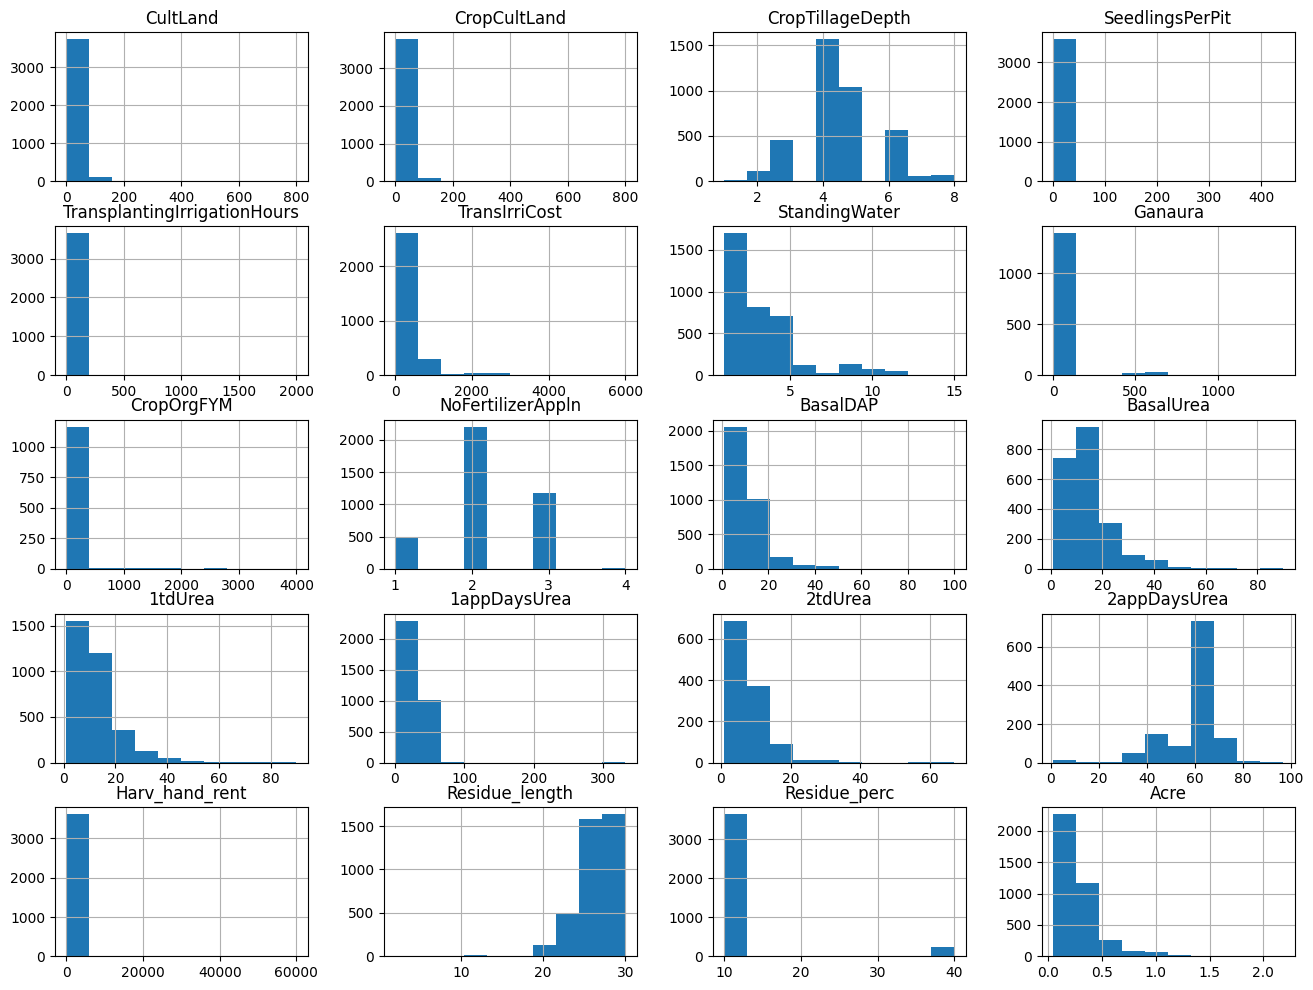

In [ ]:
# distribution of numerical features
train_df.drop(columns='Yield').hist(figsize=(16,12));

In [ ]:
# unique values of categorical values, exempt ID and Dates
categorical_cols = train_df.drop(['CropTillageDate', 'RcNursEstDate',  'Harv_date', 'Threshing_date', 'SeedingSowingTransplanting', 'ID'], axis=1).select_dtypes(include='object').columns
for col in categorical_cols:
  print(col)
  print(train_df[col].unique())
  print()

District
['Nalanda' 'Gaya' 'Vaishali' 'Jamui']

Block
['Noorsarai' 'Rajgir' 'Gurua' 'Garoul' 'Khaira' 'Jamui' 'Mahua'
 'Chehrakala' 'Wazirganj']

LandPreparationMethod
['TractorPlough FourWheelTracRotavator'
 'WetTillagePuddling TractorPlough FourWheelTracRotavator'
 'TractorPlough WetTillagePuddling' 'TractorPlough'
 'FourWheelTracRotavator' 'WetTillagePuddling'
 'TractorPlough BullockPlough'
 'WetTillagePuddling TractorPlough FourWheelTracRotavator BullockPlough'
 'WetTillagePuddling TractorPlough BullockPlough'
 'WetTillagePuddling TractorPlough' 'FourWheelTracRotavator TractorPlough'
 'WetTillagePuddling FourWheelTracRotavator'
 'WetTillagePuddling FourWheelTracRotavator BullockPlough TractorPlough'
 'WetTillagePuddling BullockPlough TractorPlough FourWheelTracRotavator'
 'TractorPlough WetTillagePuddling FourWheelTracRotavator'
 'BullockPlough TractorPlough WetTillagePuddling FourWheelTracRotavator'
 'WetTillagePuddling FourWheelTracRotavator TractorPlough'
 'WetTillagePuddling Fo

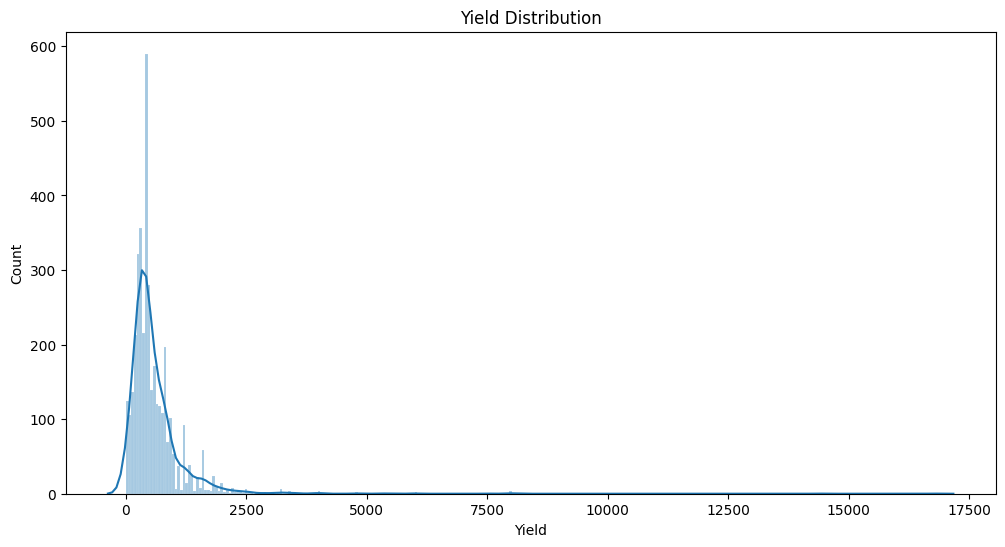

In [ ]:
# Distribution of target variable - 'Yield'
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(train_df['Yield'], kde=True, kde_kws=dict(cut=3),
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
ax.set_title('Yield Distribution')
ax.set_xlabel('Yield');

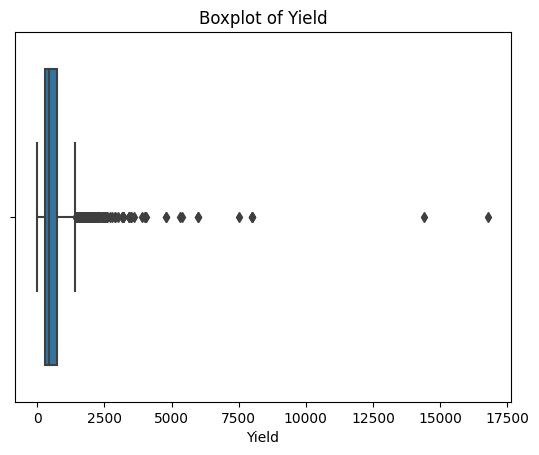

In [ ]:
# show outliers in Yield column
sns.boxplot(x=train_df['Yield'])
plt.xlabel('Yield')
plt.title('Boxplot of Yield')
plt.show()

In [ ]:
# def yield_distribution(col):
#   col_unique_values = train[col].unique()
#   for value in col_unique_values:
#       col_data = train[train[col] == value]

#       # Create a histogram or distplot for each district
#       plt.figure(figsize=(8, 6))
#       sns.histplot(col_data['Yield'], kde=True)
#       plt.title(f'Distribution of Yield in {value}')
#       plt.xlabel('Yield')
#       plt.ylabel('Frequency')
#       plt.show()
# yield_distribution('Block')

# # Winsorization to sort outliers
# train_df.loc[train_df['Yield'] > 5000, 'Yield'] = 5000

<ipython-input-16-ba02c143b8a5>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(train_df.corr(), dtype=bool))
<ipython-input-16-ba02c143b8a5>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), linewidths=0.5, mask=mask, square=True, ax=ax, annot=True);


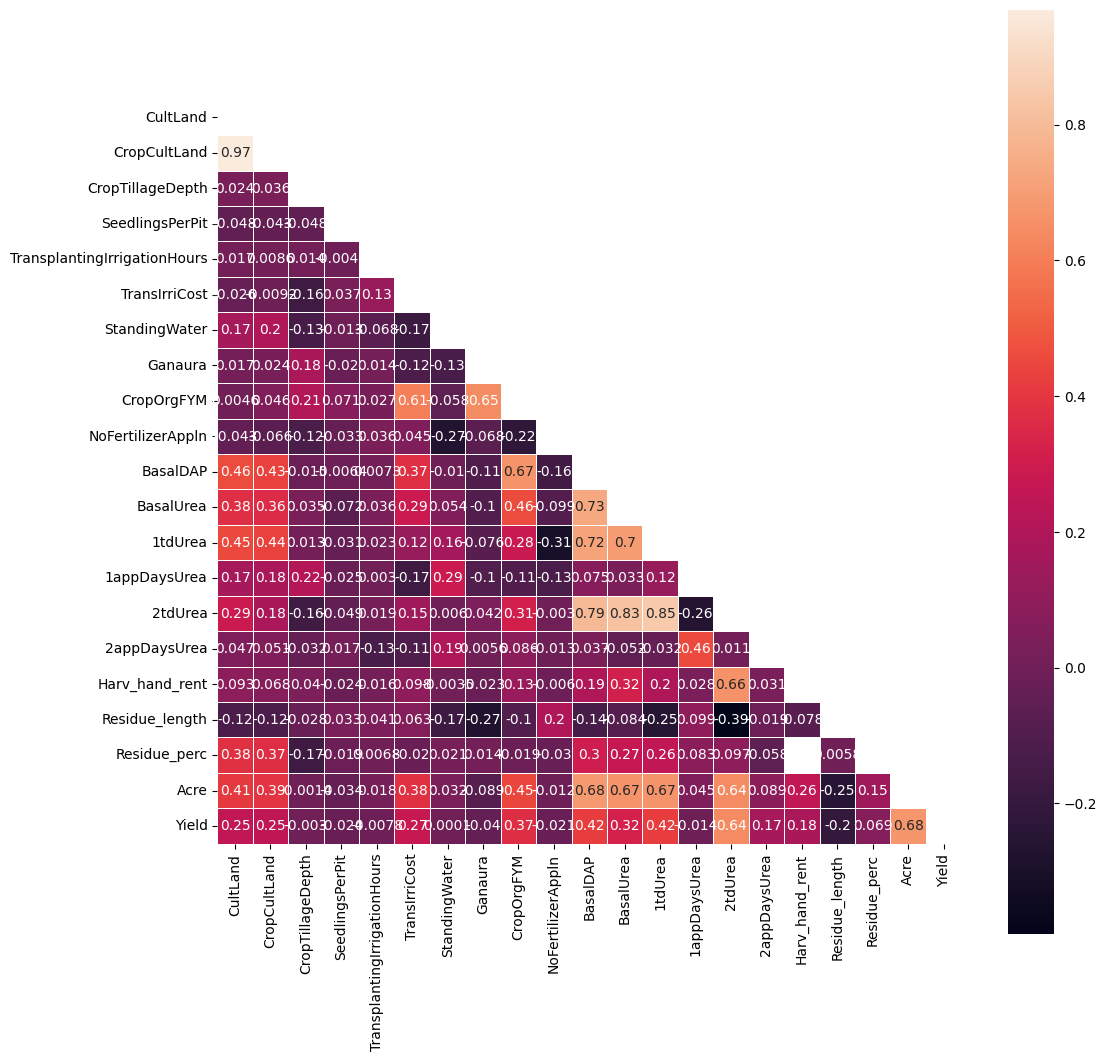

In [ ]:
#using a heatmap to show correlation
fig, ax = plt.subplots(figsize=(12,12))
mask = np.triu(np.ones_like(train_df.corr(), dtype=bool))
sns.heatmap(train_df.corr(), linewidths=0.5, mask=mask, square=True, ax=ax, annot=True);

Acre has the highest correlation with the yield

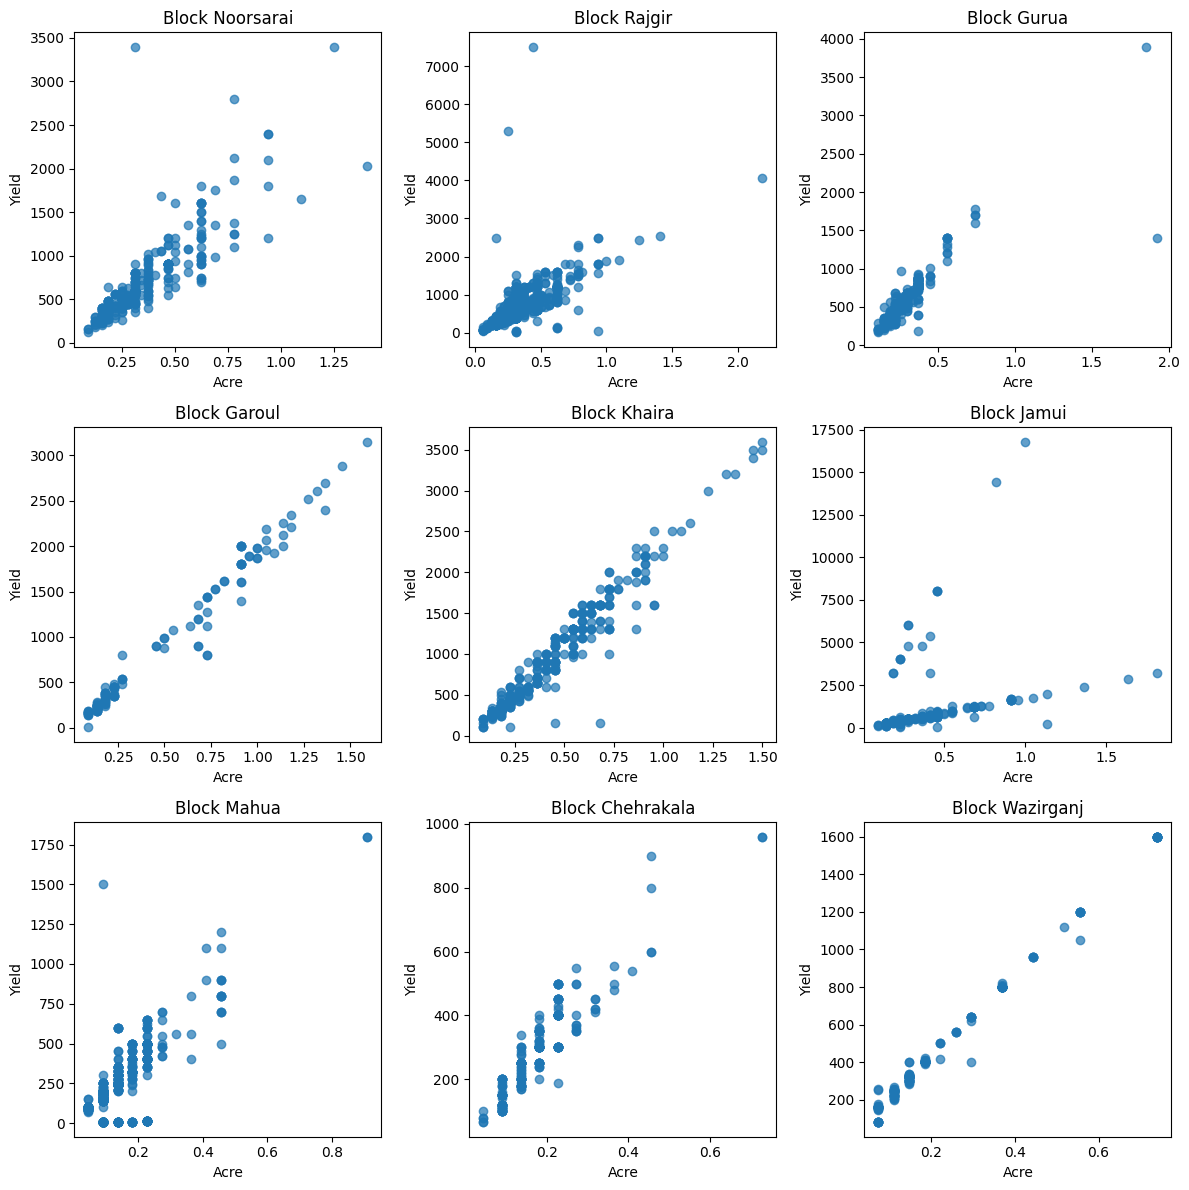

In [ ]:
#  scatter plot showing the correlation between Acre and Yield per block
blocks = train_df['Block'].unique()

# Create subplots in 3 columns
num_blocks = len(blocks)
num_cols = 3
num_rows = int(np.ceil(num_blocks / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))

# Plot for each block
for i, block in enumerate(blocks):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    # Filter data for the current block
    block_data = train_df[train_df['Block'] == block]

    # Plot Acre vs. Yield for the current block
    ax.scatter(block_data['Acre'], block_data['Yield'], alpha=0.7)
    ax.set_title(f"Block {block}")
    ax.set_xlabel('Acre')
    ax.set_ylabel('Yield')

# Hide empty subplots if the number of blocks is not a multiple of 3
for i in range(num_blocks, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


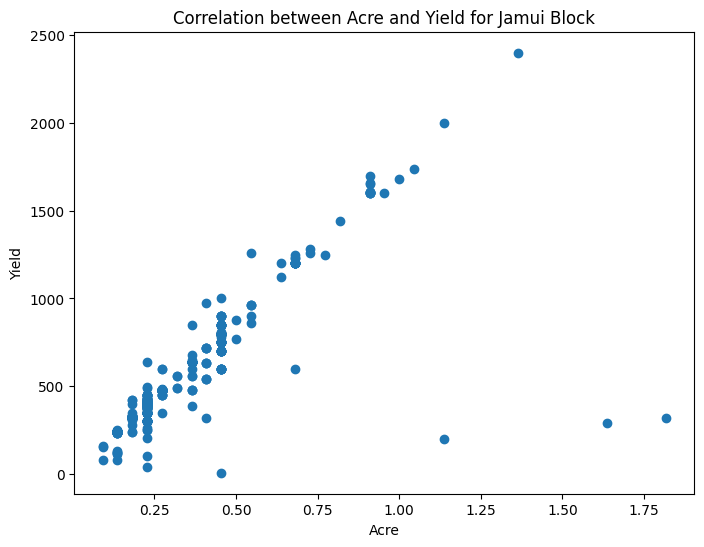

In [ ]:
# Filter data for Jamui Block and apply the condition to Yield
jamui_data = train_df[(train_df['Block'] == 'Jamui')]
jamui_data.loc[jamui_data['Yield'] > 2500, 'Yield'] /= 10

# Plotting the scatter plot for Jamui Block
plt.figure(figsize=(7, 5))
plt.scatter(jamui_data['Acre'], jamui_data['Yield'])
plt.title('Correlation between Acre and Yield for Jamui Block')
plt.xlabel('Acre')
plt.ylabel('Yield')
plt.show()

In [ ]:
# Filtering Jamui Block in the training data and modifying 'Yield' column
jamui_indices = train_df['Block'] == 'Jamui'
train_df.loc[jamui_indices & (train_df['Yield'] > 2500), 'Yield'] /= 10

## Data Cleaning

#### Duplicates

In [ ]:
# check for duplicates
train_df.duplicated(subset='ID').value_counts()

False    3870
dtype: int64

No duplicates

#### Wrong data types and Values

The values are wrong as they have CropTillageDate as 19/07/2022 and 25/07/2022, yet Harv_date of 01/12/2021 and 03/12/2021 respectively

Discrepancies identified in the function 'calculate_time_differences'

In [ ]:
train_df.loc[train_df['ID'] == 'ID_YTZN9FE7PQUY', 'Harv_date'] = '2022-11-04'
train_df.loc[train_df['ID'] == 'ID_9P3DV08LL3SX', 'Harv_date'] = '2022-12-01'
train_df.loc[train_df['ID'] == 'ID_RL2F5BMVBUAX', 'Harv_date'] = '2022-12-03'

In [ ]:
# Convert date columns to datetime format
date_cols = ['CropTillageDate', 'RcNursEstDate', 'Harv_date', 'Threshing_date', 'SeedingSowingTransplanting']
train_df[date_cols] = train_df[date_cols].apply(pd.to_datetime, format='%Y-%m-%d', errors='coerce')
test[date_cols] = test[date_cols].apply(pd.to_datetime, format='%Y-%m-%d', errors='coerce')

#### Missing values

In [ ]:
# check for missing values - train
null_columns = train_df.columns[train_df.isna().any()]
null_counts = train_df[null_columns].isna().sum()

# Display the result
for col, count in zip(null_columns, null_counts):
    print(f"{col} : {count}")

RcNursEstDate : 83
SeedlingsPerPit : 289
NursDetFactor : 289
TransDetFactor : 289
TransplantingIrrigationHours : 193
TransplantingIrrigationSource : 115
TransplantingIrrigationPowerSource : 503
TransIrriCost : 882
StandingWater : 238
OrgFertilizers : 1335
Ganaura : 2417
CropOrgFYM : 2674
PCropSolidOrgFertAppMethod : 1337
CropbasalFerts : 188
BasalDAP : 543
BasalUrea : 1704
FirstTopDressFert : 485
1tdUrea : 556
1appDaysUrea : 556
2tdUrea : 2694
2appDaysUrea : 2700
MineralFertAppMethod.1 : 481
Harv_hand_rent : 252


In [ ]:
# check for missing values - test
null_columns = test.columns[test.isna().any()]
null_counts = test[null_columns].isna().sum()

# Display the result
for col, count in zip(null_columns, null_counts):
    print(f"{col} : {count}")

RcNursEstDate : 43
SeedlingsPerPit : 103
NursDetFactor : 103
TransDetFactor : 103
TransplantingIrrigationHours : 77
TransplantingIrrigationSource : 46
TransplantingIrrigationPowerSource : 171
TransIrriCost : 317
StandingWater : 79
OrgFertilizers : 415
Ganaura : 795
CropOrgFYM : 868
PCropSolidOrgFertAppMethod : 416
CropbasalFerts : 76
BasalDAP : 191
BasalUrea : 571
FirstTopDressFert : 149
1tdUrea : 177
1appDaysUrea : 178
2tdUrea : 875
2appDaysUrea : 882
MineralFertAppMethod.1 : 146
Harv_hand_rent : 73


In [ ]:
def replace_nulls(df):
    df = df.copy()
    # Replace nulls with 'Unknown'
    cols1 = ['NursDetFactor', 'TransDetFactor', 'TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource',
             'OrgFertilizers', 'PCropSolidOrgFertAppMethod', 'CropbasalFerts', 'FirstTopDressFert', 'MineralFertAppMethod.1']
    df[cols1] = df[cols1].fillna('None')

    # Replace nulls with 0
    cols2 = ['Ganaura', 'CropOrgFYM', 'BasalDAP', 'BasalUrea', '1tdUrea', '2tdUrea', 'Harv_hand_rent', 'TransIrriCost', 'StandingWater', '1appDaysUrea', '2appDaysUrea']
    df[cols2] = df[cols2].fillna(0)

    # Replace with mean
    df.loc[df['TransplantingIrrigationSource'] == '', 'TransplantingIrrigationHours'] = 0
    cols3 = ['SeedlingsPerPit', 'TransplantingIrrigationHours']
    block_means = df.groupby('Block')[cols3].transform('mean')
    df[cols3] = df[cols3].fillna(block_means)

    # Fill null values in RcNursEstDate by adding the average difference to CropTillageDate per block
    average_difference = df.groupby('Block')['RcNursEstDate', 'CropTillageDate'].apply(lambda x: (x['RcNursEstDate'] - x['CropTillageDate']).mean())
    df['RcNursEstDate'].fillna(df['CropTillageDate'] + pd.to_timedelta(df['Block'].map(average_difference)), inplace=True)

    return df

# Applying the function to train_df and test_df
train_df = replace_nulls(train_df)
test = replace_nulls(test)

<ipython-input-29-e159665198ec>:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_difference = df.groupby('Block')['RcNursEstDate', 'CropTillageDate'].apply(lambda x: (x['RcNursEstDate'] - x['CropTillageDate']).mean())
<ipython-input-29-e159665198ec>:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_difference = df.groupby('Block')['RcNursEstDate', 'CropTillageDate'].apply(lambda x: (x['RcNursEstDate'] - x['CropTillageDate']).mean())


## Data preparation for Machine Learning

Drop ID, NursDetFactor and TransDetFactor columns. Focus more on the dates rather than the reasons for choosing the date of nursery/transplantation

In [ ]:
# Features(X) and target(y)
# to_drop = ['ID', 'NursDetFactor',  'TransDetFactor', 'LandPreparationMethod', 'OrgFertilizers', 'CropbasalFerts',
#            'FirstTopDressFert', 'CropEstMethod', 'PCropSolidOrgFertAppMethod', 'MineralFertAppMethod', 'MineralFertAppMethod.1']
X_train = train_df.drop(['ID', 'NursDetFactor',  'TransDetFactor', 'Yield'], axis = 1)
y_train = train_df.Yield
X_test = test.drop(['ID', 'NursDetFactor',  'TransDetFactor'], axis=1)

##### Feature Engineering

**Date transformations:**

In [ ]:
def calculate_time_differences(df, df_name="DataFrame"):
    # Calculate time differences between different stages
    df['Tillage_to_Sowing_Duration'] = (df['SeedingSowingTransplanting'] - df['CropTillageDate']).dt.days
    df['Sowing_to_Harvest_Duration'] = (df['Harv_date'] - df['SeedingSowingTransplanting']).dt.days
    df['Nursery_to_Sowing_Duration'] = (df['SeedingSowingTransplanting'] - df['RcNursEstDate']).dt.days
    df['Harvest_to_Threshing_Duration'] = (df['Threshing_date'] - df['Harv_date']).dt.days

    # Check for negative values in the columns
    negative_columns = df.loc[:, df.columns.str.endswith('_Duration')].columns[df.loc[:, df.columns.str.endswith('_Duration')].lt(0).any()]
    if len(negative_columns) > 0:
        print(f"{df_name} columns with negative values in time difference columns:")
        print(negative_columns)
        print(f"Rows with negative values in {df_name}:")
        rows_with_negatives = df[df[negative_columns].lt(0).any(axis=1)]
        print(rows_with_negatives)

    return df

X_train = calculate_time_differences(X_train, "X_train")
X_test = calculate_time_differences(X_test, "X_test")

In [ ]:
def extract_date_features(df, date_column):
    # Extract day features
    df[f'{date_column}Day'] = df[date_column].dt.dayofyear

    # Drop original date column
    df.drop(date_column, axis=1, inplace=True)

date_columns = ['CropTillageDate', 'RcNursEstDate', 'SeedingSowingTransplanting', 'Harv_date', 'Threshing_date']
for column in date_columns:
    extract_date_features(X_train, column)
    extract_date_features(X_test, column)
X_train.head(2)

,District,Block,CultLand,CropCultLand,LandPreparationMethod,CropTillageDepth,CropEstMethod,SeedlingsPerPit,TransplantingIrrigationHours,TransplantingIrrigationSource,...,Acre,Tillage_to_Sowing_Duration,Sowing_to_Harvest_Duration,Nursery_to_Sowing_Duration,Harvest_to_Threshing_Duration,CropTillageDateDay,RcNursEstDateDay,SeedingSowingTransplantingDay,Harv_dateDay,Threshing_dateDay
0,Nalanda,Noorsarai,45,40,TractorPlough FourWheelTracRotavator,5,Manual_PuddledRandom,2.0,5.0,Boring,...,0.3125,1,118,24,0,201,178,202,320,320
1,Nalanda,Rajgir,26,26,WetTillagePuddling TractorPlough FourWheelTrac...,5,Manual_PuddledRandom,2.0,5.0,Boring,...,0.3125,2,128,30,29,199,171,201,329,358


**Fertilizer Transformations**

In [ ]:
def fertilizer_transformation(data):
  # Total Fertilizer Applied
  data['Total_Organic_Fertilizer'] = data['Ganaura'] + data['CropOrgFYM']

  # Total Urea Applied
  urea_columns = ['BasalUrea', '1tdUrea', '2tdUrea']
  data['Total_Urea_Applied'] = data[urea_columns].sum(axis=1)

  # Average Days Between Urea Applications
  urea_application_days = ['1appDaysUrea', '2appDaysUrea']
  data['Avg_Days_Between_Urea_Applications'] = data[urea_application_days].mean(axis=1)

fertilizer_transformation(X_train)
fertilizer_transformation(X_test)
X_train.shape

(3870, 47)

**Transform columns with multiple values per row**

In [ ]:
def transform_columns(X_train, X_test, column_name):
    unique_values_train = set()

    # Extract unique values from the training set
    for methods in X_train[column_name].str.split():
        unique_values_train.update(methods)

    # Create binary columns for each unique value in the training set
    for value in unique_values_train:
        new_col_name = column_name[:5] + '_' + value if len(value) >= 5 else column_name[:5] + '_' + '_' + value
        new_col_name = new_col_name.replace(" ", "")

        # Apply the tranformation to both train and test sets
        X_train[new_col_name] = X_train[column_name].str.contains(value).astype(int)
        X_test[new_col_name] = X_test[column_name].str.contains(value).astype(int)

    return X_train, X_test

# Apply the function to the specified columns for both train and test sets
columns_to_encode = ['LandPreparationMethod', 'OrgFertilizers', 'CropbasalFerts', 'FirstTopDressFert']

for col in columns_to_encode:
    X_train, X_test = transform_columns(X_train, X_test,  col)
    # Drop the original column after encoding for both train and test sets
    X_train.drop(col, axis=1, inplace=True)
    X_test.drop(col, axis=1, inplace=True)
print(X_train.shape)
print(X_train.columns)

(3870, 71)
Index(['District', 'Block', 'CultLand', 'CropCultLand', 'CropTillageDepth',
       'CropEstMethod', 'SeedlingsPerPit', 'TransplantingIrrigationHours',
       'TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource',
       'TransIrriCost', 'StandingWater', 'Ganaura', 'CropOrgFYM',
       'PCropSolidOrgFertAppMethod', 'NoFertilizerAppln', 'BasalDAP',
       'BasalUrea', 'MineralFertAppMethod', '1tdUrea', '1appDaysUrea',
       '2tdUrea', '2appDaysUrea', 'MineralFertAppMethod.1', 'Harv_method',
       'Harv_hand_rent', 'Threshing_method', 'Residue_length', 'Residue_perc',
       'Stubble_use', 'Acre', 'Tillage_to_Sowing_Duration',
       'Sowing_to_Harvest_Duration', 'Nursery_to_Sowing_Duration',
       'Harvest_to_Threshing_Duration', 'CropTillageDateDay',
       'RcNursEstDateDay', 'SeedingSowingTransplantingDay', 'Harv_dateDay',
       'Threshing_dateDay', 'Total_Organic_Fertilizer', 'Total_Urea_Applied',
       'Avg_Days_Between_Urea_Applications', 'LandP_Bull

#### Check for multicollinearity

In [ ]:
# pairs with collinearity > 0.75
df = X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df['pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)
df.columns = ['cc']
df.drop_duplicates(inplace=True)
df[(df.cc>.75) & (df.cc<1)]

<ipython-input-35-47777fd5bdcd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)


,cc
pairs,
"(CropCultLand, CultLand)",0.969350
"(First__None, First__Urea)",0.924124
"(CropOrgFYM, Total_Organic_Fertilizer)",0.922814
"(Avg_Days_Between_Urea_Applications, 2appDaysUrea)",0.890100
"(Avg_Days_Between_Urea_Applications, NoFertilizerAppln)",0.872176
"(2appDaysUrea, NoFertilizerAppln)",0.830097
"(1tdUrea, Total_Urea_Applied)",0.822936
"(First__NPKS, First__NPK)",0.796896
"(Total_Urea_Applied, BasalUrea)",0.764207


In [ ]:
# drop some columns to address the collinearity
to_drop = ['CultLand', 'First__None', 'CropOrgFYM', 'Avg_Days_Between_Urea_Applications', '2appDaysUrea', '1tdUrea', 'First__NPK', 'BasalUrea']
X_train = X_train.drop(columns = to_drop)
X_test = X_test.drop(columns = to_drop)
print(X_train.shape)

(3870, 63)


#### Transform Categorical Variables

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer

# # Assuming cat_cols contains the names of categorical columns
# cat_cols = X.select_dtypes(include='object').columns
# print(cat_cols)

# # Create a ColumnTransformer for encoding categorical columns
# one_hot_encoding = ColumnTransformer(
#     transformers=[
#         ('onehot', OneHotEncoder(drop="if_binary", handle_unknown='ignore'), cat_cols)
#     ],
#     remainder='passthrough'  # Include non-categorical columns as is
# )

In [ ]:
cat_cols = ['District', 'Block', 'CropEstMethod', 'TransplantingIrrigationSource',
       'TransplantingIrrigationPowerSource', 'PCropSolidOrgFertAppMethod',
       'MineralFertAppMethod', 'MineralFertAppMethod.1']
transform_dict = {}
combined = pd.concat([X_train[cat_cols], X_test[cat_cols]], ignore_index=True)

for col in combined:
    categories = combined[col].astype('category').cat.categories
    d = {cat: i for i, cat in enumerate(categories)}
    transform_dict[col] = d

transform_dict

# Apply transformation to X
for col in cat_cols:
    X_train[col] = X_train[col].map(transform_dict[col])

# Apply transformation to test_df
for col in cat_cols:
    X_test[col] = X_test[col].map(transform_dict[col])
X_train.head()

,District,Block,CropCultLand,CropTillageDepth,CropEstMethod,SeedlingsPerPit,TransplantingIrrigationHours,TransplantingIrrigationSource,TransplantingIrrigationPowerSource,TransIrriCost,...,Cropb__NPK,Cropb__DAP,Cropb_Other,Cropb__None,Cropb__Urea,First__SSP,First__NPKS,First__DAP,First__Urea,First_Other
0,2,7,40,5,3,2.0,5.000000,0,1,200.0,...,0,0,0,0,1,0,0,0,1,0
1,2,8,26,5,3,2.0,5.000000,0,1,125.0,...,0,1,0,0,1,0,0,0,1,0
2,0,2,10,6,3,2.0,4.000000,0,1,80.0,...,0,1,0,0,0,0,0,0,1,0
3,0,2,15,6,3,2.0,7.108392,2,2,0.0,...,0,1,0,0,1,0,0,0,1,0
4,2,7,60,4,3,2.0,9.000000,0,1,300.0,...,0,1,0,0,1,0,0,0,1,0


In [ ]:
# Assuming cat_cols contains the names of categorical columns
cols_OHE = ['Harv_method', 'Threshing_method', 'Stubble_use']

# Reset indices before concatenation
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Perform OneHotEncoding
encoder = OneHotEncoder(sparse=False, drop='if_binary', handle_unknown='ignore')
encoded_train = encoder.fit_transform(X_train[cols_OHE])
encoded_test_df = encoder.transform(X_test[cols_OHE])

# Create DataFrames for encoded columns
encoded_df_train = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(cols_OHE))
encoded_df_test_df = pd.DataFrame(encoded_test_df, columns=encoder.get_feature_names_out(cols_OHE))

# Concatenate DataFrames properly
X_train = pd.concat([X_train.drop(cols_OHE, axis=1), encoded_df_train], axis=1)
X_test = pd.concat([X_test.drop(cols_OHE, axis=1), encoded_df_test_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Modeling

In [ ]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Define models
models = {
    'Random Forest': RandomForestRegressor(random_state=1234),
    'XGBoost': XGBRegressor(random_state=1234),
    'LGBM': LGBMRegressor(random_state=1234),
    'SVR': SVR(),
    'AdaBoost': AdaBoostRegressor(random_state=1234),
    'ElasticNet': ElasticNet(random_state=1234),
    'Lasso': Lasso(random_state=1234),
    'KNN': KNeighborsRegressor(),
    'GradientBoosting': GradientBoostingRegressor(random_state=1234),
    'BaggingRegressor': BaggingRegressor(random_state=1234)
}

# Loop through models
results = {}
for model_name, model in models.items():
    pipe = Pipeline(steps=[
        # ('encoding', one_hot_encoding),
        ('scale', StandardScaler()),
        # ('pca', pca),  # Add PCA after encoding
        (model_name.lower(), model)
    ])
    kfold = KFold(n_splits=5, shuffle=True, random_state=1234)
    scores = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    rmse_scores = (-scores) ** 0.5
    results[model_name] = rmse_scores.mean()
results

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1496
[LightGBM] [Info] Number of data points in the train set: 3096, number of used features: 54
[LightGBM] [Info] Start training from score 572.290052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1504
[LightGBM] [Info] Number of data points in the train set: 3096, number of used features: 54
[LightGBM] [Info] Start training from score 566.788114
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

{'Random Forest': 201.40985011537003,
 'XGBoost': 210.84531885968713,
 'LGBM': 197.31003210971835,
 'SVR': 453.47546704822525,
 'AdaBoost': 350.4282771106388,
 'ElasticNet': 264.8610051126413,
 'Lasso': 221.83516821679459,
 'KNN': 254.9408672561894,
 'GradientBoosting': 209.2472490901302,
 'BaggingRegressor': 210.8732796450226}

In [ ]:
# Instantiate and fit model
LGBM = LGBMRegressor(random_state=1234)
LGBM.fit(X_train_scaled, y_train)

# Measure train model performance
train_preds = LGBM.predict(X_train_scaled)
print(mean_squared_error(y_train, train_preds, squared=False))

preds = LGBM.predict(X_test_scaled)
sub = pd.DataFrame({'ID': test.ID, 'Yield': preds})
sub.to_csv('BenchmarkSubmission.csv', index = False)
sub.tail(3)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 3870, number of used features: 55
[LightGBM] [Info] Start training from score 568.720413
120.71046415407451


,ID,Yield
1287,ID_01YVA2LJVYBR,243.243314
1288,ID_YQRL2IOUU4SZ,361.640545
1289,ID_VAX2N8ELPEZE,334.512449


The model is overfitting.

In [ ]:
# # Best Model
# pipe = Pipeline(steps=[
#   ('scale', StandardScaler()),
#   ('RFR', RandomForestRegressor(random_state=1234))
# ])
# kfold = KFold(n_splits=5, shuffle=True, random_state=1234)
# scores = cross_val_score(pipe,X , y, cv=kfold, scoring='neg_mean_squared_error')
# rmse_scores = (-scores) ** 0.5
# print(rmse_scores)

# # Train the pipeline on the entire training dataset
# pipe.fit(X, y)

##### Feature Selection

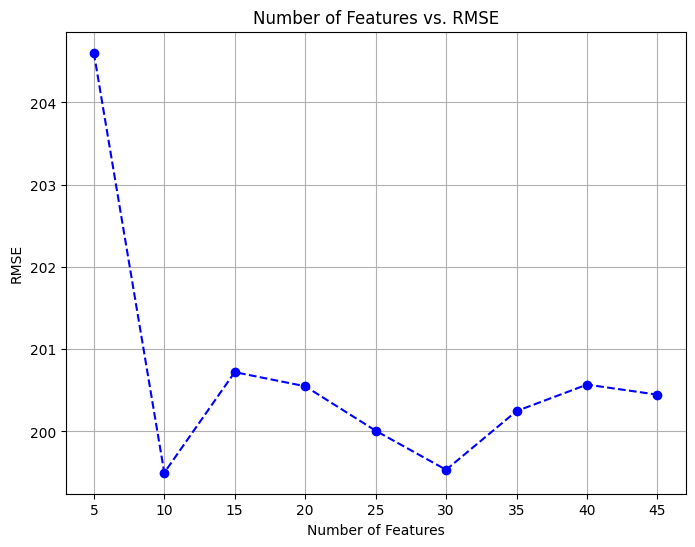

In [ ]:
# Instantiate and fit model
model = RandomForestRegressor(random_state = 1234)
model.fit(X_train_scaled, y_train)

# Extract feature importances
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

# Define the range of feature counts you want to test
num_features_to_test = range(5, 50, 5)

# Store RMSE scores for different feature counts
rmse_scores = []

for num_features in num_features_to_test:
    # Select top features based on importance
    selected_features = feature_importances.nlargest(num_features).index

    # Filter the training  set with selected features
    X_train_selected = pd.DataFrame(X_train_scaled, columns=X_train.columns)[selected_features]

    # Train a model using selected features
    rf = RandomForestRegressor(random_state=123)

    # Evaluate RMSE using cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=1234)
    scores = cross_val_score(rf, X_train_selected, y_train, cv=kfold, scoring='neg_mean_squared_error')
    rmse = (-scores.mean()) ** 0.5
    rmse_scores.append(rmse)

# Plotting number of features vs. RMSE
plt.figure(figsize=(8, 6))
plt.plot(num_features_to_test, rmse_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.title('Number of Features vs. RMSE')
plt.grid(True)
plt.show()

#### Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV


# Define the range of hyperparameters for the RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [None, 5, 10, 15, 20],
    'max_features': [1.0, 'sqrt', 'log2', 20, 25]
}


# Instantiate RandomForestRegressor
rf = RandomForestRegressor(random_state=1234)

# Grid search with cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1234)
grid_search = GridSearchCV(rf, param_grid, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
(-1 * grid_search.best_score_)** 0.5

125.85148893830299

In [ ]:
print(best_params)

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 400}


In [ ]:
# Fit the best model on the entire training set
best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=1234)
best_rf.fit(X_train_scaled, y_train)
train_preds = best_rf.predict(X_train_scaled)
print(mean_squared_error(y_train, train_preds, squared=False))

# Predict on the training set to get RMSE
# X_test_selected = pd.DataFrame(X_test_scaled, columns=X_test.columns)[best_selected_features]
preds = best_rf.predict(X_test_scaled)

sub = pd.DataFrame({'ID': test.ID, 'Yield': preds})
sub.to_csv('BenchmarkSubmission.csv', index = False)

sub.tail(2)

46.52623444779275


,ID,Yield
1288,ID_YQRL2IOUU4SZ,381.711748
1289,ID_VAX2N8ELPEZE,357.753979


In [ ]:
# # Make predictions on the Zindi test set
# test_df_selected = pd.DataFrame(test_df_scaled, columns=test_df.columns)[selected_features]
# preds = model_selected.predict(test_df_selected)
# sub = pd.DataFrame({'ID': test.ID, 'Yield': preds})
# sub.to_csv('BenchmarkSubmission.csv', index = False)

# sub.head(3)

In [ ]:
# from lazypredict.Supervised import LazyRegressor
# from sklearn.utils import shuffle
# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)
# print(models)

##### Neural Networks: MLPRegressor

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer


# Custom scoring function for RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create a pipeline with scaling and the neural network
model = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))

# Perform 5-fold cross-validation using RMSE as the scoring metric
kfold = KFold(n_splits=5, shuffle=True, random_state=1234)
scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring=make_scorer(rmse, greater_is_better=False))

# Print the scores
print("Cross-Validation RMSE Scores:")
print(-scores)  # Negative as sklearn convention is to maximize scores

# Calculate mean and standard deviation of the RMSE scores
mean_rmse = -scores.mean()
std_rmse = scores.std()

print(f"Mean RMSE: {mean_rmse}")
print(f"Standard deviation of RMSE: {std_rmse}")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Cross-Validation RMSE Scores:
[316.34578667 353.43743711 317.65847232 434.09253523 276.66559869]
Mean RMSE: 339.639966003987
Standard deviation of RMSE: 53.109761506363135


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Fit the model on the whole training set
model.fit(X_train, y_train)

# Predict on the training set
train_predictions = model.predict(X_train)

# Calculate RMSE on the training set
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
print(f"RMSE on Training Set: {train_rmse}")

# Predict on the test set
preds = model.predict(X_test)

sub = pd.DataFrame({'ID': test.ID, 'Yield': preds})
sub.to_csv('BenchmarkSubmission.csv', index = False)

sub.tail(2)

RMSE on Training Set: 197.97461670729757


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,ID,Yield
1288,ID_YQRL2IOUU4SZ,395.501890
1289,ID_VAX2N8ELPEZE,447.888305


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'max_iter': [500, 1000]
}

# Create the model
model = MLPRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Fit the best model on the training set
best_model.fit(X_train_scaled, y_train)

# Predict on the training set
preds = best_model.predict(X_train_scaled)

# Calculate RMSE on the training set
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
print(f"Training RMSE: {train_rmse}")

# Predict on the test set
preds = best_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Best Parameters: {'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'max_iter': 500}
Training RMSE: 304.1087212124834


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
